# Advertising: Who will most likley click an Ad

### Author: Harry Patterson

                                ====================================================

## Table of Contents

### The Problem
- [Who will click on the Ad?](#Problem)

### Data Quality Check
- [Simple Inspection of Data](#Datacleaning)

### Descriptive Statistics
- [Summary Statistics, Click Rate, Size of Data](#Descriptive_statistics)
- [Correlation Matrix](#Correlation_matrix)

### Exploratory Data Analysis
- [Area Income, Daily Time Spent on Site, Daily Internet Usage](#Eda1)
- [Age of customers](#Eda2)
- [Examine Ad Topic Line](#Eda3)
- [Some Visuals for Descriptive Figures](#Eda4)
- [Plots Against The Target Feature](#Eda5)
- [Examine Country Feature](#Eda6)
- [Examine Time Spent](#Eda7)

### Feature engineering 
- [Feature Engineering](#FE)

### Model Building 
- [Model Selection](#MS)
- [Train_Test Split](#Train_Test)
- [Logistic Regression](#LR)
- [Test Model](#Testing)
- [Random Forest](#RF)
- [Roc Graph](#Roc)
- [Feature Importance](#FI)


### Conclusion
- [The Report](#Report)
- [Actionable Recommendations](#Conclusion)

***

### Objective: 
- To understand what factors contributed most to a customer clicking on an AD.

- To create a model that predicts the likelihood if a customer will click on or not. 

- To create or improve different strategies to try and reach the customers that are not clicking on the AD. 

- The implementation of this model will allow company to target customers ideal to clicking on AD and  decision-making actions.

***

<a id='Problem'></a>
### The Problem


- Marketing campaign that needs to determine who will most likely click on the ad. 

- For each customer targeted with the ad campaign and clicks on the ad. The company gets a profit

- For each customer targeted that does not end up clicking on the ad, The company will incur a loss. 


***

## IMPORT LIBRARIES

In [1]:
# Importing librairies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, fbeta_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
%matplotlib inline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [85]:
# Functions that we will use later on
def data_info(data):
    return data.info()

def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(numerical_vars)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data )
        

def creating_histplot(size, data, features):    # (size:(height,length))
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)                  # (rows, columns)
        sns.histplot(data[features[i]], kde = True)
        
def crossCorrelation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr,annot=True,
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
    print(corr)
    
def summary_metrics(y, y_pred):
    confmat = confusion_matrix(y, y_pred)
    TP = confmat[0,0]
    FN = confmat[0,1]
    FP = confmat[1,0]
    TN = confmat[1,1]
 
    # Print the confusion matrix
    print("Confusion matrix:\n", confmat)
    print()
    
    # Print the Accuracy Score
    print("Accuracy:", round(accuracy_score(y, y_pred),2))

    # Print the Sensitivity/recall/true positive rate
    print("Sensitivity:", round(recall_score(y, y_pred),2))

    # Precision/positive predictive value
    print("Precision:", round(precision_score(y, y_pred),2))

    print("")
    print("DETAILS")
    
    # RETURN ON TP
    print("True Positive:", round((float(TP)*100),2))
    
    # Return on FP
    print("False Positive:", round((float(FP) * -1050),2))
    
    # Return on FN
    print("False Negative:", round((float(FN) * 1100),2))
    
    # Return on TN
    print("True Negative:", round((float(TN) * 0), 2))
    
    # Return on investment
    investment_return = (TP * 100) + (FP * -1050) + (FN * 1100) + (TN * 0)
    print("Profit:", round(float(investment_return),2), "$")

# Read the Data

In [2]:
ad_df = pd.read_csv('Data/advertising.csv')
ad_df.head(10)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0
5,59.99,23,59761.56,226.74,Sharable client-driven software,Jamieberg,1,Norway,2016-05-19 14:30,0.0
6,88.91,33,53852.85,208.36,Enhanced dedicated support,Brandonstad,0,Myanmar,2016-01-28 20:59,0.0
7,66.00,48,24593.33,131.76,Reactive local challenge,Port Jefferybury,1,Australia,2016-03-07 1:40,1.0
8,74.53,30,68862.00,221.51,Configurable coherent function,West Colin,1,Grenada,2016-04-18 9:33,0.0
9,69.88,20,55642.32,183.82,Mandatory homogeneous architecture,Ramirezton,1,Ghana,2016-07-11 1:42,0.0


In [4]:
# Defining categorical, numerical, and datetime variables that we will use later
categorical_vars = ["Ad Topic Line", "City", "Country"]
numerical_vars = ["Daily Time Spent on Site", "Area Income", "Daily Internet Usage", "Male", "log_age"]
datetime_vars = "Timestamp"
target = "Clicked on Ad"

<a id='Datacleaning'></a>
# Data Quality Check
***

In [5]:
# looking at the main characteristics of our dataset
# such as the number of observations, the type of variables, the summary statistics for each variables, the number of missing data, etc.

ad_df.info()
print()
print(ad_df.isnull().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1018 non-null   float64
 1   Age                       1018 non-null   int64  
 2   Area Income               1018 non-null   float64
 3   Daily Internet Usage      1018 non-null   float64
 4   Ad Topic Line             1018 non-null   object 
 5   City                      1018 non-null   object 
 6   Male                      1018 non-null   int64  
 7   Country                   1018 non-null   object 
 8   Timestamp                 1018 non-null   object 
 9   Clicked on Ad             1014 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 79.7+ KB

Daily Time Spent on Site    False
Age                         False
Area Income                 False
Daily Internet Usage        False
Ad Topic Line               False

In [6]:
ad_df.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               4
dtype: int64

In [7]:
# Drop null values 
# Since missing values are in the target feature. I will remove those observations. 

ad_df = ad_df.dropna(axis=0)

# Verify 
ad_df.shape

(1014, 10)

In [8]:
# check for duplicates 
print('Number of duplicated records in training set: ', ad_df.duplicated().sum())

Number of duplicated records in training set:  7


In [9]:
# Removing duplicates and verify 
ad_df = ad_df.drop_duplicates()
print('Number of duplicated records in training set: ', ad_df.duplicated().sum())

Number of duplicated records in training set:  0


<a id='Descriptive_statistics'></a>
# Exploratory Data Analysis
***

In [10]:
# Looking at the distribution of the target feature
# Percentage of e-sign or not

click_rate = ad_df['Clicked on Ad'].value_counts() / ad_df.shape[0]
click_rate

1.0    0.502483
0.0    0.497517
Name: Clicked on Ad, dtype: float64

***
- Does show balanced data set for our class feature 

In [11]:
# noticed timestamp was an object. So, i Will convert to datetime

ad_df['Timestamp'] = pd.to_datetime(ad_df['Timestamp'])

In [12]:
# Extract descriptive statistics
# Can see age min and max is not right 
ad_df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000
mean,64.952403,36.958292,54899.398868,179.386514,0.482622,0.502483
std,15.850441,31.729539,13458.555374,44.548765,0.499946,0.500242
min,32.600000,-25.000000,13996.500000,23.640000,0.000000,0.000000
25%,51.270000,29.000000,46899.780000,138.490000,0.000000,0.000000
50%,68.100000,35.000000,56984.090000,182.200000,0.000000,1.000000
75%,78.535000,42.000000,65350.775000,218.550000,1.000000,1.000000
max,91.430000,999.000000,79484.800000,269.960000,1.000000,1.000000


In [13]:
# check to see is there any real significance for the people that clicked on the add and who didn't 
# show mean summary

clicked_summary = ad_df.groupby('Clicked on Ad')
clicked_summary.mean()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male
Clicked on Ad,,,,,
0.0,76.874431,31.680639,61372.745768,214.225549,0.500998
1.0,53.148182,42.183794,48490.017846,144.891739,0.464427


***
- We Can see the customers that clicked on the ad spent more time on the site which is about 77%, are younger in age, area have more income and a significant amount of more iternet usage. 

In [14]:
clicked_summary.std()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male
Clicked on Ad,,,,,
0.0,7.565474,6.207238,8899.793771,24.707413,0.500499
1.0,12.774535,43.731130,14130.632875,30.865242,0.499226


<a id='Correlation_matrix'></a>
### Correlation Matrix

***

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
Daily Time Spent on Site,1.000000,-0.117818,0.313744,0.511165,-0.019838,-0.748804
Age,-0.117818,1.000000,-0.093987,-0.135403,0.024832,0.165591
Area Income,0.313744,-0.093987,1.000000,0.344059,-0.005560,-0.478839
Daily Internet Usage,0.511165,-0.135403,0.344059,1.000000,0.018591,-0.778556
Male,-0.019838,0.024832,-0.005560,0.018591,1.000000,-0.036593
Clicked on Ad,-0.748804,0.165591,-0.478839,-0.778556,-0.036593,1.000000


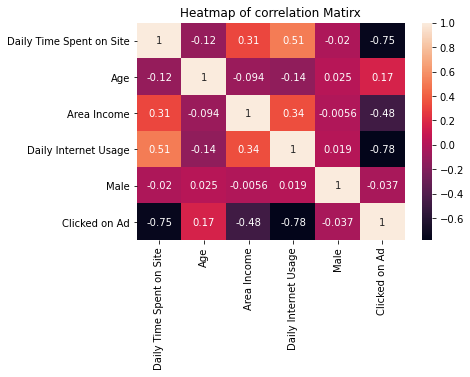

In [15]:
# Create a correlation matrix
corr = ad_df.corr()
sns.heatmap(corr,
            annot=True,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)
plt.title('Heatmap of correlation Matirx')
corr

- This correlation heatmap shows that daily time spent is the most correlated with customers who clicke on Ad. 

<a id='Eda1'></a>
# EDA 1. 
## Distribution of Area Income, Daily Time Spent on Site, Daily Internet Usage

***

Text(0, 0.5, 'Customer Count')

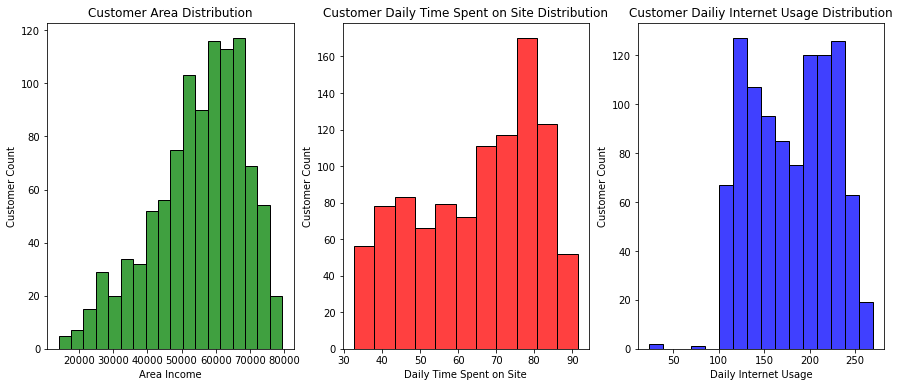

In [16]:
# Plot the distribution of Area Income, Daily Time Spent on Site, Daily Internet Usage

# Set up the matplotlib figure 
f, axes = plt.subplots(ncols=3,figsize=(15,6))

# Graph Area Income
sns.histplot(ad_df['Area Income'],kde=False,color='g',ax=axes[0]).set_title('Customer Area Distribution')
axes[0].set_ylabel('Customer Count')

# Graph employee evaluation
sns.histplot(ad_df['Daily Time Spent on Site'],kde=False,color='r',ax=axes[1]).set_title('Customer Daily Time Spent on Site Distribution')
axes[1].set_ylabel('Customer Count')

# Graph employee Average Monthly Hours
sns.histplot(ad_df['Daily Internet Usage'],kde=False,color='b',ax=axes[2]).set_title('Customer Dailiy Internet Usage Distribution')
axes[2].set_ylabel('Customer Count')

***
- We would like to see how does these features effect clicking on Ad. 
- Can notice that the data shows a considerable amount of customers with a higher income above 60,000. 
- Big difference with about 170 customers spending about 775-80 hours on site. 
- Can notice more customers are spending more than 150 hours on internet usage. 

<a id='Eda2'></a>
# EDA 2.
## Age Of Customers

- Investigate the age column due to minimum being -25 and max being 999

***

In [17]:
# Just taking a look at the various ages in the dataset 
ad_df['Age'].value_counts()

 31     60
 36     50
 28     48
 29     48
 33     43
 30     40
 34     39
 35     39
 32     38
 26     37
 38     37
 37     36
 40     36
 27     33
 41     32
 45     30
 39     30
 25     27
 42     26
 43     23
 44     21
 24     21
 50     20
 23     19
 46     19
 49     18
 48     16
 52     15
 47     14
 22     13
 51     12
 53     10
 54      9
 55      7
 57      6
 20      6
 19      6
 21      6
 58      4
 60      4
 59      2
 56      2
 999     1
-25      1
 61      1
 103     1
 8       1
Name: Age, dtype: int64

In [18]:
ad_df['Age'].sort_values()

294    -25
823      8
713     19
358     19
785     19
      ... 
635     60
185     60
684     61
604    103
495    999
Name: Age, Length: 1007, dtype: int64

<AxesSubplot:xlabel='Index', ylabel='Age'>

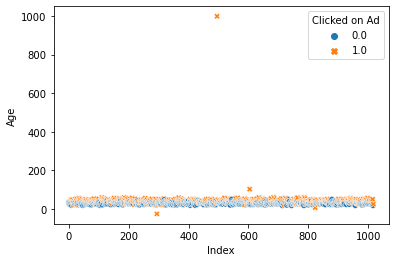

In [19]:
# visualize the age values including the extreme ages

ad_df['Index'] = ad_df.index
sns.scatterplot(data=ad_df, x='Index', y="Age",style='Clicked on Ad', hue='Clicked on Ad')

- Can notice the outliers of the age column

In [20]:
# Extract age data above 100 and younger than 18. May assume you do not want to target minors 

ad_df[(ad_df['Age'] > 100) | (ad_df['Age']< 18)]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Index
294,56.01,-25,46339.25,127.26,Re-engineered real-time success,Garciamouth,0,Tonga,2016-07-05 18:59:00,1.0,294
495,50.60,999,34191.13,129.88,Realigned reciprocal framework,New Daniellefort,1,United States of America,2016-05-03 12:57:00,1.0,495
604,57.20,103,57739.03,110.66,Innovative maximized groupware,East Heatherside,0,New Zealand,2016-03-19 11:09:00,1.0,604
823,43.16,8,25371.52,156.11,Implemented didactic support,Williamsport,1,Marshall Islands,2016-07-06 03:40:00,1.0,823


In [21]:
# will drop the rows with the their age being older than 100 and younger than 18 

ad_df = ad_df[(ad_df['Age'] >= 18) & (ad_df['Age'] < 100)]

In [22]:
# checking work
ad_df[(ad_df['Age'] > 100) | (ad_df['Age']< 18)]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Index


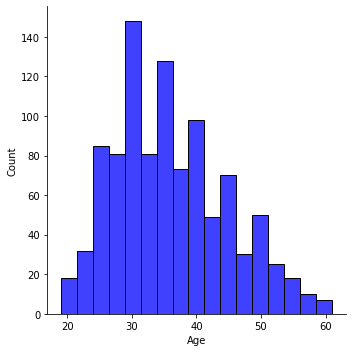

In [23]:
# Visualizing the distribution of Age 
sns.displot(ad_df, x="Age",kde=False,color='b')

In [24]:
# Just checking the age range
age_count = ad_df['Age'].value_counts(bins=2)
age_count

(18.956999999999997, 40.0]    712
(40.0, 61.0]                  291
Name: Age, dtype: int64

In [25]:
ad_df = ad_df.drop(['Index'],axis=1)
ad_df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:00,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:00,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:00,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:00,0.0


- There are a much higher amount of customers in this data that are between the ages of around 28 and 35

<a id='Eda3'></a>
# EDA 3.
## Examine Ad Topic Line

***

In [26]:
ad_df['Ad Topic Line'].value_counts()

Operative actuating installation                  2
Horizontal hybrid challenge                       2
Fundamental zero tolerance solution               2
Fully-configurable eco-centric frame              1
Monitored national standardization                1
                                                 ..
Polarized tangible collaboration                  1
Realigned global initiative                       1
Intuitive transitional artificial intelligence    1
Down-sized bandwidth-monitored core               1
Synergistic non-volatile analyzer                 1
Name: Ad Topic Line, Length: 1000, dtype: int64

In [27]:
# There are an considerable amount of different values using the Ad Topic Line
ad_df['Ad Topic Line'].nunique()

1000

- We will most likely drop Ad Topic line due to so many different values. 

<a id='eda5'></a>
# EDA 4.
##  Descriptive Figures

***

### Distribution Plots

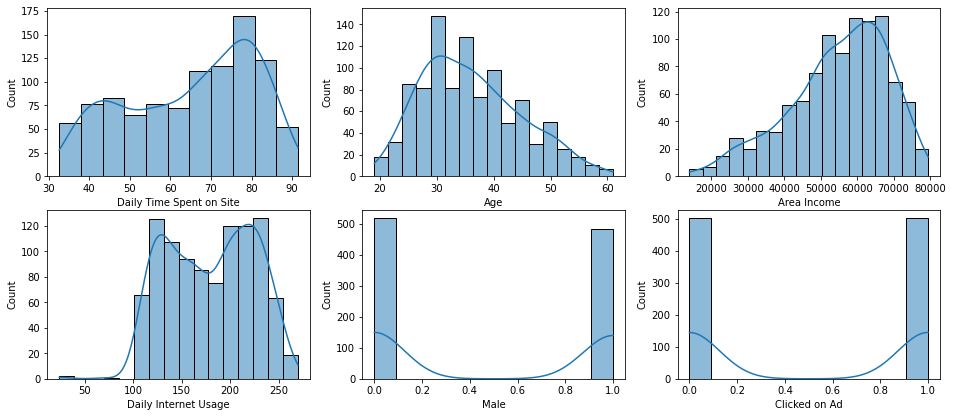

In [43]:
num_vars = ad_df.select_dtypes(exclude=['object', 'datetime64']).columns

# Creating distribution plots
creating_histplot((16,18), ad_df, num_vars)

- Age fairly right skewed, Data is kind of telling us that there may be two different groups due to bi model features 
- Area income shows a moderate left skew or negatively skewed. 

- From the overall distributions, we can observe interesting bimodal distributions for the "daily internet usage", and "daily time spent on site" which could suggest the presence of more than one group. Furthermore, the age and "area income" are little bit skewed which could potentially bias our model later on. In a subsequent step, we will apply log transformation at least on the age feature. 

### Boxplots

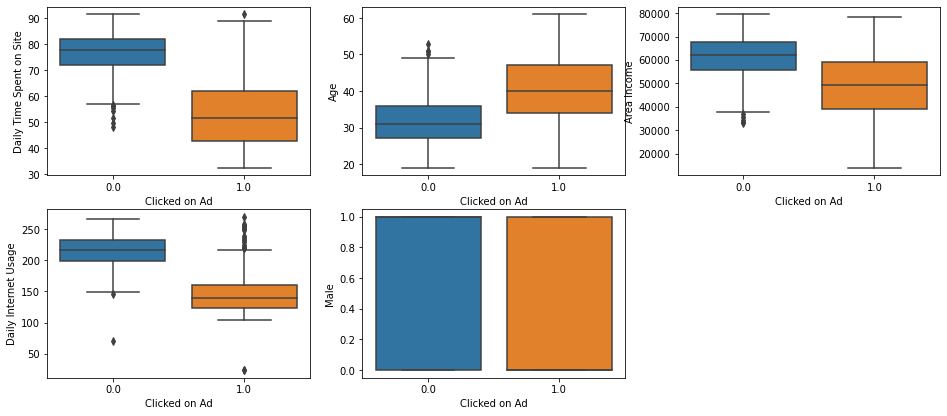

In [29]:
# Generating boxplots with respect to our target feature
creating_boxplots((16,18), target, num_vars, ad_df)

- Both boxplots on "Daily time spent on site" and "Daily internet usage" show a significant difference between the two groups, namely the people who clicked on the ad vs. the people who did not. Furthermore, we can observe a potential trend between these two groups  with age and area income respectively. 

                          Daily Time Spent on Site       Age  Area Income  \
Daily Time Spent on Site                  1.000000 -0.332547     0.310781   
Age                                      -0.332547  1.000000    -0.185785   
Area Income                               0.310781 -0.185785     1.000000   
Daily Internet Usage                      0.510199 -0.367615     0.342989   
Male                                     -0.018570 -0.019215    -0.002140   
Clicked on Ad                            -0.748192  0.494041    -0.477471   

                          Daily Internet Usage      Male  Clicked on Ad  
Daily Time Spent on Site              0.510199 -0.018570      -0.748192  
Age                                  -0.367615 -0.019215       0.494041  
Area Income                           0.342989 -0.002140      -0.477471  
Daily Internet Usage                  1.000000  0.017751      -0.777817  
Male                                  0.017751  1.000000      -0.036877  
Clicked on Ad   

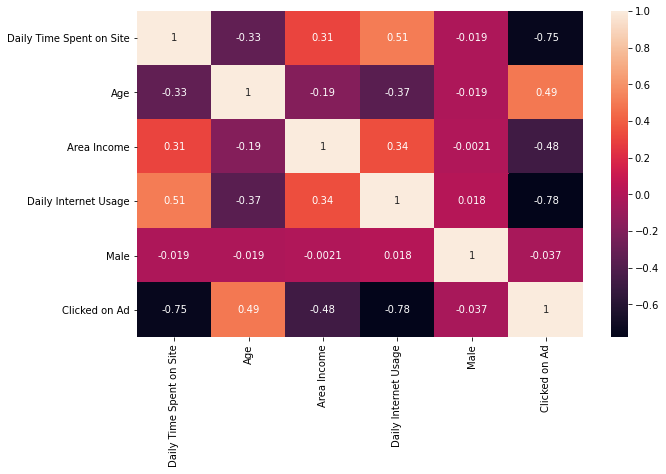

In [30]:
# Cross-correlation between the different features
# Do not want all features correlated with eachother
# Want to pay attention to explanatory features are not correlating with each other (features around .75 to pay attention too)
crossCorrelation(ad_df)

- The cross-correlation revealed interesting potential relationship between our target feature and all the features except sex. Now, we would need to keep these relationship in mind since there seems to be some collinearity between the explanatory features as well.
- Daily internet usages shows the most correlation with -78% which means as the internet usage goes up the less a customer is likey to not click on an Ad. 

<a id='Eda5'></a>
# EDA 5.
##  Distribution/Pair Plots With Respect To Our Target Feature

***

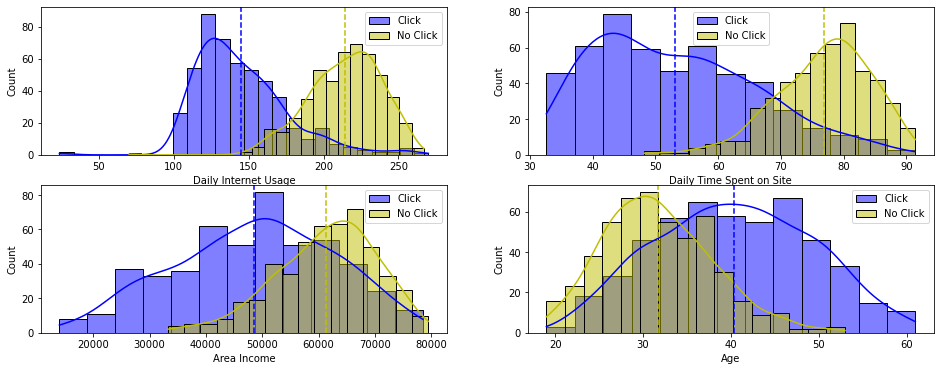

In [31]:
# Subsetting by clicks
click_yes = ad_df["Clicked on Ad"] == 1
click_no = ad_df["Clicked on Ad"] == 0

# Creating the plots
features = ["Daily Internet Usage", "Daily Time Spent on Site", "Area Income", "Age"]
labels = ["Click", "No Click"]

def creating_plots(features, labels):
    plt.figure(figsize=(16,6))
    for feature in features:
        plt.subplot(2, 2, features.index(feature)+1)
        sns.histplot(ad_df[feature][click_yes], label=labels[0], color="b",kde=True)
        sns.histplot(ad_df[feature][click_no], label=labels[1], color="y",kde=True)
        plt.axvline(ad_df[feature][click_yes].mean(), linestyle = '--', color="b")
        plt.axvline(ad_df[feature][click_no].mean(), linestyle = '--', color="y")
        plt.legend()

creating_plots(features, labels)

***
- People that clicked yes are on the left side and People that did not click are on the right side. Binomial distribution in dataset which tells us, We do have two different groups of individual features 
- These plots still verify that 

<Figure size 432x288 with 0 Axes>

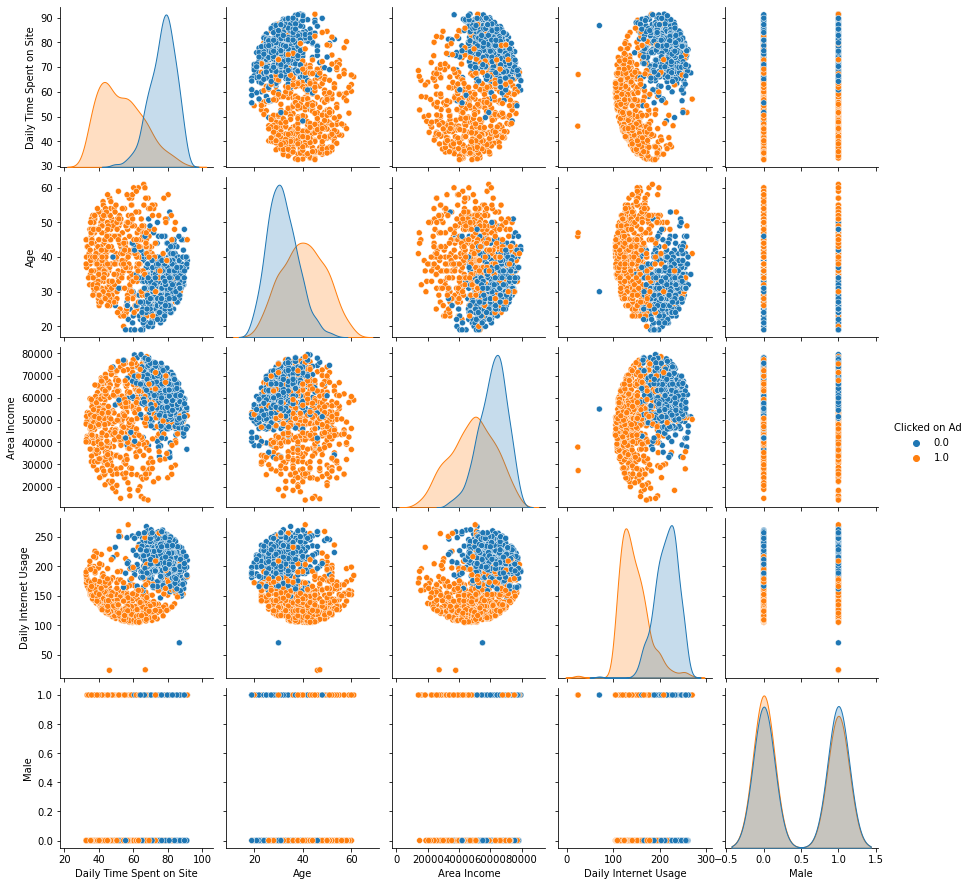

In [32]:
# Pair Plots With Respect To Our Target Feature

plt.figure()
sns.pairplot(data=ad_df[num_vars],
             hue="Clicked on Ad",
             dropna=True)

***
- Can see some seperation between each feature and the target variable

<a id='Eda6'></a>
# EDA 6.
## Examine Country Feature

***

In [45]:
ad_df['Country'].nunique()

237

In [46]:
# highest count onuniqueindividual countries is 9 out of a total of a 1000 observations. So, there may not be important due to a high spread

table_country = pd.crosstab(index=ad_df['Country'],columns='count')
table_country.sort_values(['count'],ascending=False).head(10)

col_0,count
Country,
France,9
Czech Republic,9
Afghanistan,8
Australia,8
Turkey,8
South Africa,8
Senegal,8
Peru,8
Micronesia,8


In [47]:
ad_df.Country.value_counts()

Czech Republic           9
France                   9
Australia                8
Turkey                   8
Afghanistan              8
                        ..
Lesotho                  1
Bermuda                  1
Cape Verde               1
Saint Kitts and Nevis    1
Romania                  1
Name: Country, Length: 237, dtype: int64

In [48]:
table_clicked_country = pd.crosstab(ad_df["Country"],
                                    ad_df["Clicked on Ad"], rownames=['Country'],
                                    colnames=["Clicked On Ad"])
table_clicked_country.sort_values(1, 0, ascending=False).head(10)

Clicked On Ad,0.0,1.0
Country,,
Australia,1,7
Turkey,1,7
Ethiopia,0,7
Liberia,2,6
South Africa,2,6
Liechtenstein,0,6
Senegal,3,5
Peru,3,5
Mayotte,1,5


*** 
- We can see that the users are fairly spread out acroos the globe; the the maximum users from one country reaches only 9, and that is for 237 different countries to consider. Therefore it makes it not very interesting to look at the city distribution.
- Regarding the categorical variables, we have almost all different cities, and we do not observe a huge amount of people within the same city, so we can guess that this feature has probably no predictive power. However, we have less diversity when it comes down to the different countries.

<a id='Eda7'></a>
# EDA 7.
## Examining Time Spent

***

In [49]:
# Would assume that the daily time spent would be smaller than the daily internet usage
# subract daily internet usage from daily time spent. Should be 0 or positive number

ad_df = ad_df.assign(Delta = ad_df['Daily Internet Usage'] - ad_df['Daily Time Spent on Site'])
sum(ad_df['Delta'] < 0)

3

In [50]:
# Keeping rows with delta greater than 0

ad_df = ad_df[ad_df['Delta'] >= 0 ]
ad_df

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Delta
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0.0,187.14
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:00,0.0,113.54
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:00,0.0,167.03
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:00,0.0,171.74
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:00,0.0,157.21
...,...,...,...,...,...,...,...,...,...,...,...
1013,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2016-02-11 21:49:00,1.0,135.61
1014,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,2016-04-22 02:07:00,1.0,83.12
1015,51.63,51,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,2016-02-01 17:24:00,1.0,68.74
1016,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:00,0.0,132.40


In [51]:
# Checking work
sum(ad_df['Delta'] < 0)

0

<a id='FE'></a>
# FEATURE ENGINEERING


### Skewed Features: Log Transform
- I will transform some features to avoid introducing some bias due to the overall distribution of the latter. I have some skewed distributions and they can make the models underperform. I will apply a logarithmic transformation to reduce the effect of outliers and reduce the distribution's range to solve this issue. 

- From our previous EDA, I observed that "Age" was right skewed; therefore this transformation will be applied to this feature.

***

In [52]:
ad_df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Delta
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0.0,187.14
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:00,0.0,113.54
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:00,0.0,167.03
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:00,0.0,171.74
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:00,0.0,157.21


In [53]:
ad_df['log_age'] = np.log(ad_df['Age'])

In [54]:
ad_df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad', 'Delta', 'log_age'],
      dtype='object')

In [55]:
# Reorder target column to be last

ad_df = ad_df[['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Delta', 'log_age', 'Clicked on Ad']]

ad_df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Delta,log_age,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,187.14,3.555348,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:00,113.54,3.433987,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:00,167.03,3.258097,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:00,171.74,3.367296,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:00,157.21,3.555348,0.0


### REMOVING FEATURES

In [56]:
ad_df1 = ad_df.drop(['Ad Topic Line', 'Timestamp','City'],axis=1)

In [57]:
ad_df1.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country,Delta,log_age,Clicked on Ad
0,68.95,35,61833.90,256.09,0,Tunisia,187.14,3.555348,0.0
1,80.23,31,68441.85,193.77,1,Nauru,113.54,3.433987,0.0
2,69.47,26,59785.94,236.50,0,San Marino,167.03,3.258097,0.0
3,74.15,29,54806.18,245.89,1,Italy,171.74,3.367296,0.0
4,68.37,35,73889.99,225.58,0,Iceland,157.21,3.555348,0.0


### NORMALIZATION OF NUMERICAL FEATURES

In [58]:
# Since a regression approach will be used. Will need to standardize observations 
# Making sure the overall interval is within the same range

# Defining categorical, numerical, and datetime variables that we will use later
categorical_vars = ["Ad Topic Line", "City", "Country"]
numerical_vars = ["Daily Time Spent on Site", "Area Income", "Daily Internet Usage", "Male",'Delta', "log_age"]
datetime_vars = "Timestamp"
target = "Clicked on Ad"

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

# Applying the MinMax transformation of the numerical variables
ad_df1 = pd.DataFrame(data = ad_df1)
ad_df1[numerical_vars] = scaler.fit_transform(ad_df1[numerical_vars])

# Show an example of a record with scaling applied
ad_df1.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country,Delta,log_age,Clicked on Ad
0,0.617882,35,0.730472,0.916031,0.0,Tunisia,0.853679,0.523740,0.0
1,0.809621,31,0.831375,0.538746,1.0,Nauru,0.435782,0.419696,0.0
2,0.626721,26,0.699200,0.797433,0.0,San Marino,0.739496,0.268903,0.0
3,0.706272,29,0.623160,0.854280,1.0,Italy,0.766239,0.362521,0.0
4,0.608023,35,0.914568,0.731323,0.0,Iceland,0.683738,0.523740,0.0


### Processing Categorical Feature: One Hot-Encoding

In [59]:
# encode the categorical features for machine learning algorithm. 
# This function is fed with the entire dataset
ad_df_final = pd.get_dummies(ad_df1)

In [60]:
ad_df_final.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Delta,log_age,Clicked on Ad,Country_Afghanistan,Country_Albania,...,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela,Country_Vietnam,Country_Wallis and Futuna,Country_Western Sahara,Country_Yemen,Country_Zambia,Country_Zimbabwe
0,0.617882,35,0.730472,0.916031,0.0,0.853679,0.523740,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.809621,31,0.831375,0.538746,1.0,0.435782,0.419696,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.626721,26,0.699200,0.797433,0.0,0.739496,0.268903,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.706272,29,0.623160,0.854280,1.0,0.766239,0.362521,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.608023,35,0.914568,0.731323,0.0,0.683738,0.523740,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='MS'></a>
# Model Selection

In this section, I will test various algorithms with our problem at hand to choose the best one in order to tune the model to its best parameters and to assess the different algorithms, I will use these two metrics:

    - F1-Score (Allows you to put more weight on the precision or the recall part depending on the problem)
    
    - Accuracy: Tells us how often the classifer is right
    

***

<a id='Train_Test'></a>
# Data Preparation: Training and Testing Sets

***

In [78]:
# Create separate object for target variable
y = ad_df_final['Clicked on Ad']

# Create separate object for input features
X = ad_df_final.drop('Clicked on Ad', axis=1)

In [79]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [80]:
# Just checking 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 244)
(800,)
(200, 244)
(200,)


<a id='LR'></a>
## Model Selection: Logistic Regression

- Want to be able to explain how the different features are either contributing or not to the model
- Will use logistic regression 
- First, I will perform a general gridsearch on the penalizing parameter of the L2-Regularization. I will use this search as a guideline for a more focus search in the next step.

***

The previous step highlighted a value of 10 for the C parameter used in the L2-Regularization. We will now perform another search with a much narrower search in order to identify the best parameter.

### Use Logistic Regression on Training data

In [81]:
# Can be tricky using regulazation becasue you don't know where to start
# Start with a broad interval, run model once then you have a idea of a value helps the model then investigate the range. 


parameters = {"C": [0.001, 0.01, 0.1, 1, 10 , 100, 1000]}

model = LogisticRegression(random_state=42, penalty="l2", max_iter=1000)

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_train)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.9950
Final F-score on the testing data: 0.9965
LogisticRegression(C=10, max_iter=1000, random_state=42)


***
The previous step on training data highlighted a value of 10 for the C parameter used in the L2-Regularization. We will now perform another search with a much narrower search in order to identify the best parameter.

In [82]:
parameters = {"C": [6, 6.4, 6.6, 6.8, 6.9, 7, 8.5, 8.7, 9,10, 10.5, 12]}

model = LogisticRegression(random_state=42, penalty="l2", max_iter=1000)

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_train)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the training data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print("Final F-score on the training data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the training data: 0.9912
Final F-score on the training data: 0.9949
LogisticRegression(C=6.8, max_iter=1000, random_state=42)


***

From the logisitic regression, with a model including most of our features, our best result on the training set are:

1. Accuracy of 99%

2. F-score of 99.5%

with L2-Regularization with C=6.8.

I will now look at other metrics such as the precision and recall

### Confusion Matrix, Precision, Recall, F1-Score

In [83]:
# Confusion matrix

confmat = confusion_matrix(y_train,best_predictions)
print('The confusion matrix: \n', confmat)
print('Precision Score:', round(precision_score(y_train,best_predictions), 2))
print('Recall Score:', round(recall_score(y_train,best_predictions), 2))

The confusion matrix: 
 [[399   1]
 [  6 394]]
Precision Score: 1.0
Recall Score: 0.98


- Due to this particular business problem, I may want to try to lower the false negatives (Predict not to click on Ad but does.) since they are costing the company money when we spend money on a client that does not click on the ad. 
- We target but do not end up clicking on the AD. 
- False positive - You predicted Yes, but they were labeled as No 

In [86]:
# Getting the metrics from the confusion matrix with our best model on our training set
print(summary_metrics(y_train, best_predictions))

Confusion matrix:
 [[399   1]
 [  6 394]]

Accuracy: 0.99
Sensitivity: 0.98
Precision: 1.0

DETAILS
True Positive: 39900.0
False Positive: -6300.0
False Negative: 1100.0
True Negative: 0.0
Profit: 34700.0 $
None


As we can see, the business case lose a lot of money due to the false positives. So, I will aim to minimize the number of false positives to reduce the loss.
- With logistic regression, we have to look at the decision boundaries which is at .5  
- All values above .5 will be considered positive and below .5 will be considered negative. 

Text(0, 0.5, 'Frequency')

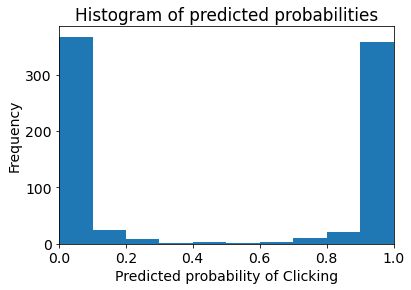

In [87]:
y_pred_prob = best_clf.predict_proba(X_train)[:,1]

plt.rcParams['font.size'] = 14
plt.hist(y_pred_prob,bins=10)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Clicking')
plt.ylabel('Frequency')

It looks like the  model does not carry a lot of ambiguity when it comes down to predicting if someone will click on the ad or not. I could still raise the threshold to 0.65 to decrease the chance of a false positive, even though this current model seems quite categorical.

In [88]:
y_pred_prob = best_clf.predict_proba(X_train)[:,1] # Generating the probabilities for each observation within training set
y_pred_class = np.where(y_pred_prob<0.45,0,1) # put threshold at .45 instead of .5 (just to see how it would change the distribution of the False positive)
summary_metrics(y_train,y_pred_class)

Confusion matrix:
 [[399   1]
 [  4 396]]

Accuracy: 0.99
Sensitivity: 0.99
Precision: 1.0

DETAILS
True Positive: 39900.0
False Positive: -4200.0
False Negative: 1100.0
True Negative: 0.0
Profit: 36800.0 $


- Looks like raising the threshold does decrease the money lost when it comes to predicting if a customer clicks on AD but does not. 

In [103]:
print('\n\n ---Logistic Regression Model --- ')
lr_auc = roc_auc_score(y_test, best_clf.predict(X_test))

print('Logistic Regression AUC = %2.2f' % lr_auc)

# lr2 = best_clf.fit(X_train,y_train)
print(classification_report(y_test,best_clf.predict(X_test)))



 ---Logistic Regression Model --- 
Logistic Regression AUC = 0.94
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       100
         1.0       0.92      0.96      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



<a id='Testing'></a>
## Test Model Logistic Regression Model

- Let's look at our test set to see how we would perform with this model

***

In [75]:
parameters = {"C": [6, 6.4, 6.6, 6.8, 6.9, 7, 7.2, 7.6, 8, 8.5, 8.7, 9,10, 10.5, 12]}

model = LogisticRegression(random_state=42, penalty="l2",max_iter=1000)

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_test)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.9400
Final F-score on the testing data: 0.9302
LogisticRegression(C=6.8, max_iter=1000, random_state=42)


In [90]:
test_predictions = best_clf.predict(X_test)
summary_metrics(y_test, test_predictions)

Confusion matrix:
 [[92  8]
 [ 4 96]]

Accuracy: 0.94
Sensitivity: 0.96
Precision: 0.92

DETAILS
True Positive: 9200.0
False Positive: -4200.0
False Negative: 8800.0
True Negative: 0.0
Profit: 13800.0 $


In [91]:
test_predictions_prob = best_clf.predict_proba(X_test)[:,1]
y_testpred_class = np.where(test_predictions_prob<0.45, 0, 1)

In [93]:
summary_metrics(y_test, y_testpred_class)

Confusion matrix:
 [[92  8]
 [ 3 97]]

Accuracy: 0.94
Sensitivity: 0.97
Precision: 0.92

DETAILS
True Positive: 9200.0
False Positive: -3150.0
False Negative: 8800.0
True Negative: 0.0
Profit: 14850.0 $


<a id='RF'></a>
# Random Forest

***

In [94]:
# Random forest Model

rf = RandomForestClassifier()

rf_result = cross_val_score(rf,X_train,y_train,cv = 5, scoring='f1')

rf_result.mean()

0.9596210227779016

In [97]:
rf = rf.fit(X_train,y_train)

print('\n\n ---Random Forest Model---')
rf_roc_auc = roc_auc_score(y_train,rf.predict(X_train))
print('Random Forest AUC = %2.2f' % rf_roc_auc)
print(classification_report(y_train,rf.predict(X_train)))



 ---Random Forest Model---
Random Forest AUC = 1.00
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       400
         1.0       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



### Prediction on test data using Random Forest

In [95]:
rf = rf.fit(X_train,y_train)

print('\n\n ---Random Forest Model---')
rf_roc_auc = roc_auc_score(y_test,rf.predict(X_test))
print('Random Forest AUC = %2.2f' % rf_roc_auc)
print(classification_report(y_test,rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.95
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94       100
         1.0       0.92      0.97      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



In [98]:
test_predictions = rf.predict(X_test)
summary_metrics(y_test, test_predictions)

Confusion matrix:
 [[89 11]
 [ 3 97]]

Accuracy: 0.93
Sensitivity: 0.97
Precision: 0.9

DETAILS
True Positive: 8900.0
False Positive: -3150.0
False Negative: 12100.0
True Negative: 0.0
Profit: 17850.0 $


<a id='Roc'></a>
# Create ROC Graph For Logistic Regression and Random Forest Model

***

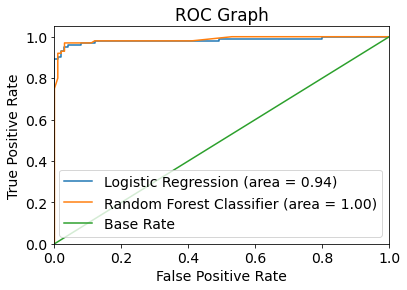

In [100]:
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
best_clf.predict_proba

plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)


# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

### Results 
- Roc Graph for both models are very close to 1 which means that both models have a good measure of separabiity. 

<a id='FI'></a>
# Feature Importance

***

In [101]:
# Get feature importance 


feature_importances = pd.DataFrame(rf.feature_importances_,
                                  index = X_train.columns,
                                  columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances

,index,importance
0,Daily Time Spent on Site,0.270465
1,Daily Internet Usage,0.240034
2,Delta,0.135335
3,log_age,0.086364
4,Area Income,0.083150
...,...,...
239,Country_Bhutan,0.000000
240,Country_Cape Verde,0.000000
241,Country_Slovenia,0.000000
242,Country_Romania,0.000000


<AxesSubplot:xlabel='importance', ylabel='index'>

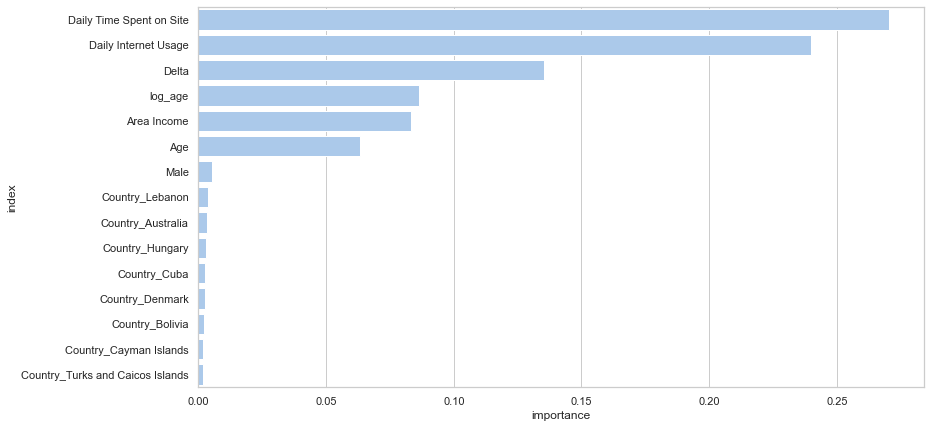

In [102]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances[:15],
            label="Total", color="b")

<a id='Report'></a>
# The Report

| Algorithm             | Accuracy | F1 Score |
|---------------------- |----------|----------|
| Randome Forest        | 93%      | 94%      |
| Logistic Regression   | 94%      | 93%.     |

***

<a id='Conclusion'></a>
# Actionable Recommendations 

Looking at the two metrics that were uses to evaluate our models. In this particular case, our F1 Score would be more important because we want to minimize the amount of money we will lose by predicting a customer would click on an AD but doesn't. But If the business determined that our true Positives and true negatives are more important then we would use accuracy.


According to the model, I can identify potential clients by getting information about users on:

- Daily Time Spent on site
- Daily Internet Usage
- Delta
- Area income
- Age

By getting this information, I can target new customers with our ad campaign to maximize the chance of a return on investment. I can speculate that the level of education could correlate with the finding since it was been previously reported that there is a correlation between the income and the level of education. 
From the exploratory data analysis and the machine learning results,  The ***targeted population*** would be customers with:

- **Lower income**
- **Spending less time on the website**
- **Spending less time on the internet**
- **Who are older than our average sample (mean around 37 years old)**
- **Customers actual difference between time spaent on internet vs time spent on website**

Also by increasing the threshold from the model, I can minimize the false positives (e.g., minimizing loss) which optimizes the business approach.